In [1]:
import numpy as np
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

In [2]:
import matplotlib.pyplot as plt  
import gym
from gym import spaces
import random
import numpy as np
import autograd.numpy as anp  
from gym.utils import seeding

In [3]:
from hbaselines.algorithms import RLAlgorithm
from hbaselines.goal_conditioned.td3 import GoalConditionedPolicy

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=4, height=4, density=1e-4, y=1, x=0, rd=-1):  # textbook rl_beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)

def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])
    
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]    


def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
    # constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [5]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        # self.flag_ = False
        self.n, self.m = x.shape
        self.x0, self.y0 = 0, 0
#         self.actions_dic={} 
    
#         k=0
#         for i in range(self.n):
#             for j in range(self.m):
#                 self.actions_dic[k]=(i,j)
#                 k+=1
        
    def action_space_(self, act, X):
#         x,y=self.actions_dic[action]
        x, y =int(act[0]), int(act[1])
#         print(x,y)
#         print(x,y)
        # penalty=(X[x][y]==1)
        X[x][y]=1
        # if penalty:
        #     return 1e-7
        # return 0
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever rl_beam design:')
        plt.imshow(X) 
        plt.show(block=False)
        plt.pause(3)
        plt.close('all')


class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"],
                # 'video.frames_per_second' : 30
                }

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        self.x0, self.y0 = 0, 0
        
#         DIM=self.args.nelx*self.args.nely 
#         self.N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        DIM=2
        self.N_DISCRETE_ACTIONS=2
        
        self.action_space = spaces.Box(low=-1, high=1,
                                       shape=(self.N_DISCRETE_ACTIONS,), dtype=np.float32)
        
        self.observation_space = spaces.Box(low=np.array([0,0]),
                                            high=np.array([self.args.nelx, self.args.nely]),
                                            shape=(DIM,),
                                           dtype=np.float32)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.layer_dim=4
        self.n_layers=2
        self.optimizer='SGD'
        self.seed()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]   
    
    def step(self, action):
        
   
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
#         vec = action /np.sqrt(np.sum(action**2))
#         print(action)


        
#         act=np.argmax(vec)
        
        self.x0, self.y0 = self.x0 + action[0], self.y0 + action[1]
        act=np.array([self.x0, self.y0])
#         print(act)

        if self.x0<0 or self.x0>=self.args.nelx or self.y0<0 or self.y0>=self.args.nely:
            done = True
        else:
            self.M.action_space_(act, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)

#         self.tmp, self.const = fast_stopt(self.args, action)
        self.step_+=1
        
        # self.reward = (1/self.tmp)**2 if self.const <0.7 else (1/self.tmp)**2-(self.const-0.7)
        self.reward += (1/self.tmp)**2

       
        done=False
            
        if self.const>0.68:
            done=True
            
              
        if self.step_ > self.M.n*self.M.m:
            done = True
#         if self.step_ >40:
#             done =True

        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        
        if done:
            self.needs_reset = True
            
#         return  self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, dict()
        return  act, self.reward, done, dict()
    
    def reset(self):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0
        
        self.x0, self.y0 = 0, 0
#         self.y=np.array([1e-4, 1e7])
#         return self.x.reshape(self.x.shape[0]*self.x.shape[1])
        return np.array([self.x0, self.y0])
       

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass
    
    @property
    def horizon(self):
        """Return the environment horizon."""
        return 1200

In [6]:
env = CantileverEnv()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
alg = RLAlgorithm(
    policy=GoalConditionedPolicy,
    env=env,
    policy_kwargs={
         # include hindsight action and goal transitions in the replay buffer
        "hindsight": True,
        # specify the sub-goal testing rate
        "subgoal_testing_rate": 0.3,
        "meta_period":9,
        "model_params":{"layers":[50, 50]},
#         "l2_penalty":0.5,
    },
    total_steps=2_000_000
)

/Users/giga/Library/CloudStorage/Dropbox/Giga/D-2018-08/implementation/projects/miscellaneous/Ocean_Intella_1/ocean_intella_1/h_base/h-baselines/hbaselines/utils/tf_util.py:427: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  val = tf.layers.dense(


In [8]:
alg.learn(log_dir="train_v1")

Done!
-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 5.461644682388019e-06          |
| rollout/return_history         | 6.388919323039458e-06          |
| total/duration                 | 10.517079830169678             |
| total/episodes                 | 117                            |
| total/epochs                   | 1                              |
| total/steps                    | 2000                           |
| total/steps_per_second         | 190.1668554671162              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 6.6979

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 1.344213554911734e-05          |
| rollout/return_history         | 1.4118987379382946e-05         |
| total/duration                 | 55.6152458190918               |
| total/episodes                 | 1412                           |
| total/epochs                   | 12                             |
| total/steps                    | 24000                          |
| total/steps_per_second         | 431.53634667135094             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 1.2058600177

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003129606046367756          |
| rollout/return_history         | 0.00033543022646426217         |
| total/duration                 | 100.84866976737976             |
| total/episodes                 | 2706                           |
| total/epochs                   | 23                             |
| total/steps                    | 46000                          |
| total/steps_per_second         | 456.12897132014564             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005875161

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005913106178739396          |
| rollout/return_history         | 0.0005891821953918495          |
| total/duration                 | 146.34822487831116             |
| total/episodes                 | 4000                           |
| total/epochs                   | 34                             |
| total/steps                    | 68000                          |
| total/steps_per_second         | 464.64519850884517             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006906652

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008331347692310098          |
| rollout/return_history         | 0.0008386451255534827          |
| total/duration                 | 191.78218984603882             |
| total/episodes                 | 5294                           |
| total/epochs                   | 45                             |
| total/steps                    | 90000                          |
| total/steps_per_second         | 469.28236700316785             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007954950

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007530136248826715          |
| rollout/return_history         | 0.0007391984932515526          |
| total/duration                 | 237.36361694335938             |
| total/episodes                 | 6588                           |
| total/epochs                   | 56                             |
| total/steps                    | 112000                         |
| total/steps_per_second         | 471.84990455688023             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007411517

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0007941219313844352          |
| rollout/return_history         | 0.0008196631062946157          |
| total/duration                 | 281.8994228839874              |
| total/episodes                 | 7882                           |
| total/epochs                   | 67                             |
| total/steps                    | 134000                         |
| total/steps_per_second         | 475.34684047631487             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006496611

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0007041314032319815          |
| rollout/return_history         | 0.0007417781605300481          |
| total/duration                 | 326.42534279823303             |
| total/episodes                 | 9176                           |
| total/epochs                   | 78                             |
| total/steps                    | 156000                         |
| total/steps_per_second         | 477.90407038471045             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005698585

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006641408286468932          |
| rollout/return_history         | 0.0007151841941969126          |
| total/duration                 | 370.905779838562               |
| total/episodes                 | 10470                          |
| total/epochs                   | 89                             |
| total/steps                    | 178000                         |
| total/steps_per_second         | 479.9062448621725              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006420201

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007369606565865507          |
| rollout/return_history         | 0.0007215529924134824          |
| total/duration                 | 415.76263666152954             |
| total/episodes                 | 11765                          |
| total/epochs                   | 100                            |
| total/steps                    | 200000                         |
| total/steps_per_second         | 481.04370706793236             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006676101

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00041650705355545715         |
| rollout/return_history         | 0.00043624711501192795         |
| total/duration                 | 460.5595746040344              |
| total/episodes                 | 13059                          |
| total/epochs                   | 111                            |
| total/steps                    | 222000                         |
| total/steps_per_second         | 482.02233161880145             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0003223307

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005132022215777512          |
| rollout/return_history         | 0.0004410258488714021          |
| total/duration                 | 505.8070447444916              |
| total/episodes                 | 14353                          |
| total/epochs                   | 122                            |
| total/steps                    | 244000                         |
| total/steps_per_second         | 482.3973935026085              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005056307

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005092284868516573          |
| rollout/return_history         | 0.00044347225242215413         |
| total/duration                 | 551.252947807312               |
| total/episodes                 | 15647                          |
| total/epochs                   | 133                            |
| total/steps                    | 266000                         |
| total/steps_per_second         | 482.5371021743345              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004796770

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006059495665840666          |
| rollout/return_history         | 0.000616495984828417           |
| total/duration                 | 595.8993196487427              |
| total/episodes                 | 16941                          |
| total/epochs                   | 144                            |
| total/steps                    | 288000                         |
| total/steps_per_second         | 483.3031193419784              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004988194

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00046312513015510376         |
| rollout/return_history         | 0.00047929800148811504         |
| total/duration                 | 640.7073400020599              |
| total/episodes                 | 18235                          |
| total/epochs                   | 155                            |
| total/steps                    | 310000                         |
| total/steps_per_second         | 483.84025068138493             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005477772

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.000468914880526545           |
| rollout/return_history         | 0.0005037378114961596          |
| total/duration                 | 685.5227966308594              |
| total/episodes                 | 19529                          |
| total/epochs                   | 166                            |
| total/steps                    | 332000                         |
| total/steps_per_second         | 484.30191035466834             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004226891

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0004906058892185496          |
| rollout/return_history         | 0.0005459306227006543          |
| total/duration                 | 730.344215631485               |
| total/episodes                 | 20823                          |
| total/epochs                   | 177                            |
| total/steps                    | 354000                         |
| total/steps_per_second         | 484.70295570687495             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005876311

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0004936916536659906          |
| rollout/return_history         | 0.0005274509811173031          |
| total/duration                 | 775.1950788497925              |
| total/episodes                 | 22117                          |
| total/epochs                   | 188                            |
| total/steps                    | 376000                         |
| total/steps_per_second         | 485.03919885288195             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005904714

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00044476267232798633         |
| rollout/return_history         | 0.0004464912289444578          |
| total/duration                 | 819.8214259147644              |
| total/episodes                 | 23412                          |
| total/epochs                   | 199                            |
| total/steps                    | 398000                         |
| total/steps_per_second         | 485.4715763934907              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006728067

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005762118034428446          |
| rollout/return_history         | 0.0005364783755291577          |
| total/duration                 | 864.5589158535004              |
| total/episodes                 | 24706                          |
| total/epochs                   | 210                            |
| total/steps                    | 420000                         |
| total/steps_per_second         | 485.79685235837536             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005381238

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007506032638641578          |
| rollout/return_history         | 0.0007917382909453113          |
| total/duration                 | 910.0816798210144              |
| total/episodes                 | 26000                          |
| total/epochs                   | 221                            |
| total/steps                    | 442000                         |
| total/steps_per_second         | 485.67069286234624             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0008006191

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00046872419004297957         |
| rollout/return_history         | 0.0005151289468463238          |
| total/duration                 | 955.0299458503723              |
| total/episodes                 | 27294                          |
| total/epochs                   | 232                            |
| total/steps                    | 464000                         |
| total/steps_per_second         | 485.84863963281043             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005296224

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007381609592161163          |
| rollout/return_history         | 0.0007364776500353897          |
| total/duration                 | 999.623471736908               |
| total/episodes                 | 28588                          |
| total/epochs                   | 243                            |
| total/steps                    | 486000                         |
| total/steps_per_second         | 486.18306166375305             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004376486

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.00028156543892968227         |
| rollout/return_history         | 0.0003015583006751255          |
| total/duration                 | 1044.5459089279175             |
| total/episodes                 | 29882                          |
| total/epochs                   | 254                            |
| total/steps                    | 508000                         |
| total/steps_per_second         | 486.3357327409305              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0002195692

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.000511715088538251           |
| rollout/return_history         | 0.0004985773583562889          |
| total/duration                 | 1089.3844978809357             |
| total/episodes                 | 31176                          |
| total/epochs                   | 265                            |
| total/steps                    | 530000                         |
| total/steps_per_second         | 486.51325682617374             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003605302

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.00018834409839855196         |
| rollout/return_history         | 0.0001853216060506514          |
| total/duration                 | 1134.5144367218018             |
| total/episodes                 | 32470                          |
| total/epochs                   | 276                            |
| total/steps                    | 552000                         |
| total/steps_per_second         | 486.5517635853213              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0001199508

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007073047547770298          |
| rollout/return_history         | 0.0006592024290083655          |
| total/duration                 | 1179.6125597953796             |
| total/episodes                 | 33765                          |
| total/epochs                   | 287                            |
| total/steps                    | 574000                         |
| total/steps_per_second         | 486.60044794671256             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005317056

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006244901164905293          |
| rollout/return_history         | 0.0005585316992080821          |
| total/duration                 | 1224.6672177314758             |
| total/episodes                 | 35059                          |
| total/epochs                   | 298                            |
| total/steps                    | 596000                         |
| total/steps_per_second         | 486.6628185769571              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0007187281

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006480366624600961          |
| rollout/return_history         | 0.0006226477902363452          |
| total/duration                 | 1270.35861992836               |
| total/episodes                 | 36353                          |
| total/epochs                   | 309                            |
| total/steps                    | 618000                         |
| total/steps_per_second         | 486.4768029321131              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005921478

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005426003188706191          |
| rollout/return_history         | 0.000487645284464977           |
| total/duration                 | 1315.9351906776428             |
| total/episodes                 | 37647                          |
| total/epochs                   | 320                            |
| total/steps                    | 640000                         |
| total/steps_per_second         | 486.346139638101               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006192836

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005797139692474901          |
| rollout/return_history         | 0.00063021614278627            |
| total/duration                 | 1362.0363557338715             |
| total/episodes                 | 38941                          |
| total/epochs                   | 331                            |
| total/steps                    | 662000                         |
| total/steps_per_second         | 486.03695284132954             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005000111

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.000592349298170888           |
| rollout/return_history         | 0.0005678240018019726          |
| total/duration                 | 1407.3004598617554             |
| total/episodes                 | 40235                          |
| total/epochs                   | 342                            |
| total/steps                    | 684000                         |
| total/steps_per_second         | 486.0369334826992              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004756100

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006213250761937837          |
| rollout/return_history         | 0.0005191678890985773          |
| total/duration                 | 1452.598471879959              |
| total/episodes                 | 41529                          |
| total/epochs                   | 353                            |
| total/steps                    | 706000                         |
| total/steps_per_second         | 486.0255698095922              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005671801

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0009188833791020738          |
| rollout/return_history         | 0.0010139017393703599          |
| total/duration                 | 1497.8442659378052             |
| total/episodes                 | 42823                          |
| total/epochs                   | 364                            |
| total/steps                    | 728000                         |
| total/steps_per_second         | 486.03183692411227             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005826840

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006554411118020235          |
| rollout/return_history         | 0.0007012972132457524          |
| total/duration                 | 1543.1247928142548             |
| total/episodes                 | 44117                          |
| total/epochs                   | 375                            |
| total/steps                    | 750000                         |
| total/steps_per_second         | 486.02679672600993             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009453423

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006419467128398678          |
| rollout/return_history         | 0.0005798655896658026          |
| total/duration                 | 1589.3161528110504             |
| total/episodes                 | 45412                          |
| total/epochs                   | 386                            |
| total/steps                    | 772000                         |
| total/steps_per_second         | 485.7435058685778              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0007899103

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0010643315394260563          |
| rollout/return_history         | 0.0011517458363881697          |
| total/duration                 | 1638.330974817276              |
| total/episodes                 | 46706                          |
| total/epochs                   | 397                            |
| total/steps                    | 794000                         |
| total/steps_per_second         | 484.63955830936743             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0012756458

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00154846320423101            |
| rollout/return_history         | 0.0015439404363944808          |
| total/duration                 | 1685.0160489082336             |
| total/episodes                 | 48000                          |
| total/epochs                   | 408                            |
| total/steps                    | 816000                         |
| total/steps_per_second         | 484.2683845822762              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0013168195

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0016825624488262302          |
| rollout/return_history         | 0.0015551899988416828          |
| total/duration                 | 1730.7313559055328             |
| total/episodes                 | 49294                          |
| total/epochs                   | 419                            |
| total/steps                    | 838000                         |
| total/steps_per_second         | 484.188373395218               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0014913283

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0019457183107534962          |
| rollout/return_history         | 0.001981814179775973           |
| total/duration                 | 1775.494904756546              |
| total/episodes                 | 50588                          |
| total/epochs                   | 430                            |
| total/steps                    | 860000                         |
| total/steps_per_second         | 484.3719898581868              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0015880310

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0019812264022055414          |
| rollout/return_history         | 0.0019900919030865186          |
| total/duration                 | 1820.3206708431244             |
| total/episodes                 | 51882                          |
| total/epochs                   | 441                            |
| total/steps                    | 882000                         |
| total/steps_per_second         | 484.5300139296231              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0018313656

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0015639264723197497          |
| rollout/return_history         | 0.0015581113141453623          |
| total/duration                 | 1865.179322719574              |
| total/episodes                 | 53176                          |
| total/epochs                   | 452                            |
| total/steps                    | 904000                         |
| total/steps_per_second         | 484.6718966849251              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0014445900

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0018046180669529352          |
| rollout/return_history         | 0.0016589052079054583          |
| total/duration                 | 1910.4132978916168             |
| total/episodes                 | 54470                          |
| total/epochs                   | 463                            |
| total/steps                    | 926000                         |
| total/steps_per_second         | 484.71186890394785             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0019247115

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0015285476520620865          |
| rollout/return_history         | 0.0014872438247662328          |
| total/duration                 | 1955.4988689422607             |
| total/episodes                 | 55765                          |
| total/epochs                   | 474                            |
| total/steps                    | 948000                         |
| total/steps_per_second         | 484.78678001628197             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0017991234

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0015582406152247626          |
| rollout/return_history         | 0.0014662803510863             |
| total/duration                 | 2001.9227678775787             |
| total/episodes                 | 57059                          |
| total/epochs                   | 485                            |
| total/steps                    | 970000                         |
| total/steps_per_second         | 484.53417662479836             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0015231308

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0015298907341705374          |
| rollout/return_history         | 0.0016191613428950566          |
| total/duration                 | 2048.1190457344055             |
| total/episodes                 | 58353                          |
| total/epochs                   | 496                            |
| total/steps                    | 992000                         |
| total/steps_per_second         | 484.34684598340476             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0017210799

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0017658401094144804          |
| rollout/return_history         | 0.0017451034309750523          |
| total/duration                 | 2093.427141904831              |
| total/episodes                 | 59647                          |
| total/epochs                   | 507                            |
| total/steps                    | 1014000                        |
| total/steps_per_second         | 484.37319823672055             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0018779204

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0011848700556014802          |
| rollout/return_history         | 0.0011856692097118892          |
| total/duration                 | 2139.46941781044               |
| total/episodes                 | 60941                          |
| total/epochs                   | 518                            |
| total/steps                    | 1036000                        |
| total/steps_per_second         | 484.23220793698255             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0011686581

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00025163009187729335         |
| rollout/return_history         | 0.0002543850737949518          |
| total/duration                 | 2185.0369398593903             |
| total/episodes                 | 62236                          |
| total/epochs                   | 529                            |
| total/steps                    | 1058000                        |
| total/steps_per_second         | 484.20234033575815             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0002631820

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00016617691730085558         |
| rollout/return_history         | 0.0001794139631552083          |
| total/duration                 | 2230.5835568904877             |
| total/episodes                 | 63530                          |
| total/epochs                   | 540                            |
| total/steps                    | 1080000                        |
| total/steps_per_second         | 484.1782306983192              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0001788445

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00021580679806058962         |
| rollout/return_history         | 0.00020291692460359584         |
| total/duration                 | 2277.7393798828125             |
| total/episodes                 | 64824                          |
| total/epochs                   | 551                            |
| total/steps                    | 1102000                        |
| total/steps_per_second         | 483.8130339813929              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0002131613

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003575979255750969          |
| rollout/return_history         | 0.0003628960116379889          |
| total/duration                 | 2328.043271780014              |
| total/episodes                 | 66118                          |
| total/epochs                   | 562                            |
| total/steps                    | 1124000                        |
| total/steps_per_second         | 482.808895188874               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003077143

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00029117839561959477         |
| rollout/return_history         | 0.00028419745980398935         |
| total/duration                 | 2375.1569998264313             |
| total/episodes                 | 67412                          |
| total/epochs                   | 573                            |
| total/steps                    | 1146000                        |
| total/steps_per_second         | 482.49442040410213             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003368480

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.00037274228111365857         |
| rollout/return_history         | 0.0003728996540657284          |
| total/duration                 | 2422.0195038318634             |
| total/episodes                 | 68706                          |
| total/epochs                   | 584                            |
| total/steps                    | 1168000                        |
| total/steps_per_second         | 482.24219423176146             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003350065

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0004055777641221668          |
| rollout/return_history         | 0.00040556000987544965         |
| total/duration                 | 2469.4445357322693             |
| total/episodes                 | 70000                          |
| total/epochs                   | 595                            |
| total/steps                    | 1190000                        |
| total/steps_per_second         | 481.8897459655343              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004068360

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.00037063445988236597         |
| rollout/return_history         | 0.0003364851041536296          |
| total/duration                 | 2516.8276748657227             |
| total/episodes                 | 71294                          |
| total/epochs                   | 606                            |
| total/steps                    | 1212000                        |
| total/steps_per_second         | 481.5585954110515              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003781726

-------------------------------------------------------------------
| rollout/episode_steps          | 16.991525423728813             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.003228555652630329           |
| rollout/return_history         | 0.003150992969750722           |
| total/duration                 | 2563.1104760169983             |
| total/episodes                 | 72589                          |
| total/epochs                   | 617                            |
| total/steps                    | 1234000                        |
| total/steps_per_second         | 481.4462784755191              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0032564511

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005084086970994952          |
| rollout/return_history         | 0.0005290621168423974          |
| total/duration                 | 2608.467892885208              |
| total/episodes                 | 73883                          |
| total/epochs                   | 628                            |
| total/steps                    | 1256000                        |
| total/steps_per_second         | 481.508706097489               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007330806

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 4.616236138161871e-05          |
| rollout/return_history         | 4.3380510199602084e-05         |
| total/duration                 | 2654.791115999222              |
| total/episodes                 | 75177                          |
| total/epochs                   | 639                            |
| total/steps                    | 1278000                        |
| total/steps_per_second         | 481.3938062012012              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0001716387

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.00015728796296044612         |
| rollout/return_history         | 0.00017005310920715412         |
| total/duration                 | 2701.5139288902283             |
| total/episodes                 | 76471                          |
| total/epochs                   | 650                            |
| total/steps                    | 1300000                        |
| total/steps_per_second         | 481.2116591729124              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003255797

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 6.708514789718174e-05          |
| rollout/return_history         | 7.172628187330781e-05          |
| total/duration                 | 2748.1069886684418             |
| total/episodes                 | 77766                          |
| total/epochs                   | 661                            |
| total/steps                    | 1322000                        |
| total/steps_per_second         | 481.0584178313077              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 7.8097130890

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00011221130478484759         |
| rollout/return_history         | 0.0001079076175060858          |
| total/duration                 | 2796.3578917980194             |
| total/episodes                 | 79060                          |
| total/epochs                   | 672                            |
| total/steps                    | 1344000                        |
| total/steps_per_second         | 480.62517460375096             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0001119302

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003761310126709995          |
| rollout/return_history         | 0.0003716576594425684          |
| total/duration                 | 2844.766534805298              |
| total/episodes                 | 80354                          |
| total/epochs                   | 683                            |
| total/steps                    | 1366000                        |
| total/steps_per_second         | 480.1800018691137              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0003622927

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003588998859014893          |
| rollout/return_history         | 0.00037698582122915254         |
| total/duration                 | 2892.937417984009              |
| total/episodes                 | 81648                          |
| total/epochs                   | 694                            |
| total/steps                    | 1388000                        |
| total/steps_per_second         | 479.789155261869               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0001439702

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006847801418166168          |
| rollout/return_history         | 0.0007085798511974768          |
| total/duration                 | 2939.19611287117               |
| total/episodes                 | 82942                          |
| total/epochs                   | 705                            |
| total/steps                    | 1410000                        |
| total/steps_per_second         | 479.7230078746374              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0004139548

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007035778961801787          |
| rollout/return_history         | 0.0007105836119096363          |
| total/duration                 | 2985.1740198135376             |
| total/episodes                 | 84236                          |
| total/epochs                   | 716                            |
| total/steps                    | 1432000                        |
| total/steps_per_second         | 479.7040274688732              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006934104

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0007702895837368432          |
| rollout/return_history         | 0.0007983482905852703          |
| total/duration                 | 3030.9647789001465             |
| total/episodes                 | 85530                          |
| total/epochs                   | 727                            |
| total/steps                    | 1454000                        |
| total/steps_per_second         | 479.7152412069983              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006277934

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006742059393509309          |
| rollout/return_history         | 0.0007369216590620759          |
| total/duration                 | 3076.9723856449127             |
| total/episodes                 | 86824                          |
| total/epochs                   | 738                            |
| total/steps                    | 1476000                        |
| total/steps_per_second         | 479.6923127701844              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008789480

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005729853246448401          |
| rollout/return_history         | 0.0005873235139418101          |
| total/duration                 | 3121.983997821808              |
| total/episodes                 | 88118                          |
| total/epochs                   | 749                            |
| total/steps                    | 1498000                        |
| total/steps_per_second         | 479.8230871923581              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003057272

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005910943357130575          |
| rollout/return_history         | 0.0005439992529929948          |
| total/duration                 | 3168.2764217853546             |
| total/episodes                 | 89413                          |
| total/epochs                   | 760                            |
| total/steps                    | 1520000                        |
| total/steps_per_second         | 479.75611898896915             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005760219

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008209218759858964          |
| rollout/return_history         | 0.0007914697962056323          |
| total/duration                 | 3214.6689558029175             |
| total/episodes                 | 90707                          |
| total/epochs                   | 771                            |
| total/steps                    | 1542000                        |
| total/steps_per_second         | 479.67614121400555             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0007986879

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005048043744580119          |
| rollout/return_history         | 0.000514793913785342           |
| total/duration                 | 3260.75248169899               |
| total/episodes                 | 92001                          |
| total/epochs                   | 782                            |
| total/steps                    | 1564000                        |
| total/steps_per_second         | 479.6438885741766              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0005266096

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0002881565109148129          |
| rollout/return_history         | 0.00024691133887319567         |
| total/duration                 | 3305.681956768036              |
| total/episodes                 | 93295                          |
| total/epochs                   | 793                            |
| total/steps                    | 1586000                        |
| total/steps_per_second         | 479.7799730106618              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0005013147

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00018954838216049506         |
| rollout/return_history         | 0.00019598396100238045         |
| total/duration                 | 3350.6227309703827             |
| total/episodes                 | 94589                          |
| total/epochs                   | 804                            |
| total/steps                    | 1608000                        |
| total/steps_per_second         | 479.9107894592188              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 9.2325534851

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0008896817834513086          |
| rollout/return_history         | 0.0009116388754875504          |
| total/duration                 | 3395.8602418899536             |
| total/episodes                 | 95883                          |
| total/epochs                   | 815                            |
| total/steps                    | 1630000                        |
| total/steps_per_second         | 479.9961965139147              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009007294

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0002925722859045894          |
| rollout/return_history         | 0.00027552275984972095         |
| total/duration                 | 3441.2364547252655             |
| total/episodes                 | 97177                          |
| total/epochs                   | 826                            |
| total/steps                    | 1652000                        |
| total/steps_per_second         | 480.06000800427097             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0001658880

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 1.3054045383108013e-05         |
| rollout/return_history         | 1.184974411795931e-05          |
| total/duration                 | 3485.9798200130463             |
| total/episodes                 | 98471                          |
| total/epochs                   | 837                            |
| total/steps                    | 1674000                        |
| total/steps_per_second         | 480.20932031492225             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 2.5872937676

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 2.50870791721696e-05           |
| rollout/return_history         | 2.5685348633476125e-05         |
| total/duration                 | 3531.058557987213              |
| total/episodes                 | 99766                          |
| total/epochs                   | 848                            |
| total/steps                    | 1696000                        |
| total/steps_per_second         | 480.3092251652604              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 2.1489712128

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 2.9650014184354225e-05         |
| rollout/return_history         | 2.8495398057426204e-05         |
| total/duration                 | 3576.0260286331177             |
| total/episodes                 | 101060                         |
| total/epochs                   | 859                            |
| total/steps                    | 1718000                        |
| total/steps_per_second         | 480.4215590837519              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 2.3474735767

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 2.0493675474771398e-05         |
| rollout/return_history         | 2.0676403075533515e-05         |
| total/duration                 | 3621.024349927902              |
| total/episodes                 | 102354                         |
| total/epochs                   | 870                            |
| total/steps                    | 1740000                        |
| total/steps_per_second         | 480.52700889311745             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 2.7879123696

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 1.756267525570218e-05          |
| rollout/return_history         | 1.8288241028650735e-05         |
| total/duration                 | 3666.135973930359              |
| total/episodes                 | 103648                         |
| total/epochs                   | 881                            |
| total/steps                    | 1762000                        |
| total/steps_per_second         | 480.61501606308684             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 1.3121436073

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 3.827709194568315e-07          |
| rollout/return_history         | 3.970455652025045e-07          |
| total/duration                 | 3711.6350667476654             |
| total/episodes                 | 104942                         |
| total/epochs                   | 892                            |
| total/steps                    | 1784000                        |
| total/steps_per_second         | 480.65070189220864             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 1.4220129528

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 6.558714971000769e-07          |
| rollout/return_history         | 7.533399585104987e-07          |
| total/duration                 | 3756.7510278224945             |
| total/episodes                 | 106236                         |
| total/epochs                   | 903                            |
| total/steps                    | 1806000                        |
| total/steps_per_second         | 480.7345460544938              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 8.2083413291

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 4.574456275991839e-06          |
| rollout/return_history         | 4.772859327559599e-06          |
| total/duration                 | 3801.7127957344055             |
| total/episodes                 | 107530                         |
| total/epochs                   | 914                            |
| total/steps                    | 1828000                        |
| total/steps_per_second         | 480.8359016628113              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 7.4482720314

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 7.2405898772896965e-06         |
| rollout/return_history         | 8.107138522564406e-06          |
| total/duration                 | 3846.9368658065796             |
| total/episodes                 | 108824                         |
| total/epochs                   | 925                            |
| total/steps                    | 1850000                        |
| total/steps_per_second         | 480.90209549412873             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 8.9998266170

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 9.712671144994825e-05          |
| rollout/return_history         | 8.820671391304668e-05          |
| total/duration                 | 3892.0616838932037             |
| total/episodes                 | 110118                         |
| total/epochs                   | 936                            |
| total/steps                    | 1872000                        |
| total/steps_per_second         | 480.97901627485277             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 7.5593453803

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00012756041371322875         |
| rollout/return_history         | 0.00013317472233992202         |
| total/duration                 | 3937.4984169006348             |
| total/episodes                 | 111413                         |
| total/epochs                   | 947                            |
| total/steps                    | 1894000                        |
| total/steps_per_second         | 481.0160664117408              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0001802224

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00035469209683513516         |
| rollout/return_history         | 0.00034374825505566593         |
| total/duration                 | 3984.146768808365              |
| total/episodes                 | 112707                         |
| total/epochs                   | 958                            |
| total/steps                    | 1916000                        |
| total/steps_per_second         | 480.90597841431037             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0003400678

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00015344410024723673         |
| rollout/return_history         | 0.00017671851641348028         |
| total/duration                 | 4031.6123099327087             |
| total/episodes                 | 114001                         |
| total/epochs                   | 969                            |
| total/steps                    | 1938000                        |
| total/steps_per_second         | 480.7009828860124              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 7.3801252492

-------------------------------------------------------------------
| rollout/episode_steps          | 16.95762711864407              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00028970310654742045         |
| rollout/return_history         | 0.0003087363747559217          |
| total/duration                 | 4078.0112788677216             |
| total/episodes                 | 115295                         |
| total/epochs                   | 980                            |
| total/steps                    | 1960000                        |
| total/steps_per_second         | 480.62642939629217             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0003621807

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0002030274806190894          |
| rollout/return_history         | 0.0001909428817834392          |
| total/duration                 | 4124.690739870071              |
| total/episodes                 | 116590                         |
| total/epochs                   | 991                            |
| total/steps                    | 1982000                        |
| total/steps_per_second         | 480.52087416920705             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0002041205


Final Cantilever rl_beam design:


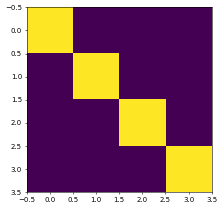

In [9]:
obs = env.reset()
done = False
while not done:
    action = alg._policy(
                    obs=obs,
                    context=None
                )
    obs, reward, done, info = env.step(action)
env.render() 